In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The dataset includes country-wide totals of energy consumption, wind power production, and solar power production for 2006 to 2016. We would like to visualize the time series data, as well as understand seasonality, frequency, and trends. We will use techniques such as time-based indexing, resampling and rolling windows to explore variations in electricity demand and renewable energy supply over time

Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:

- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh

We will explore how electricity consumption and production in Germany have varied over time, and aim to asnwer questions such as:
- When is electricity consumption typically highest and lowest?
- How do wind and solar power production vary with seasons of the year?
- What are the long-term trends in electricity consumption, solar power, and wind power?
- How do wind and solar power production compare with electricity consumption, and how has this ratio changed over time?

#### EDA and creating Time Series dataframe

In [211]:
df = pd.read_csv('data/opsd_germany_daily.csv', index_col=0, parse_dates=True)

In [212]:
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


We can see that for some dates, only the power consumption data is available while the entries for wind, solar and other renewable enrgy columns are empty

In [213]:
df.tail()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131
2017-12-30,1215.44897,721.247,7.467,728.714
2017-12-31,1107.11488,721.176,19.980,741.156


In [214]:
df.shape

(4383, 4)

We have 5 types of energy and 4383 data entries that go from Jan 1, 2006 to Dec 31, 2017

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 4 columns):
Consumption    4383 non-null float64
Wind           2920 non-null float64
Solar          2188 non-null float64
Wind+Solar     2187 non-null float64
dtypes: float64(4)
memory usage: 171.2 KB


We can see that for all renewable energy columns we have missing data. Let's count how many entries are empty

In [216]:
wind_empty = (df['Wind'].isna()).sum()
wind_empty

1463

In [217]:
solar_empty = (df['Solar'].isna()).sum()
solar_empty

2195

In [218]:
solar_wind_empty = (df['Wind+Solar'].isna()).sum()
solar_wind_empty

2196

By counting the NaN values, we see that 33% of Wind series and around 50% of the solar and Wind+Solar series have no data for the first few years

In [219]:
df_nan_percent = df.isna().sum()/df.isna().count()*100
df_nan_percent

Consumption     0.000000
Wind           33.378964
Solar          50.079854
Wind+Solar     50.102669
dtype: float64

In [220]:
df.describe()

,Consumption,Wind,Solar,Wind+Solar
count,4383.000000,2920.000000,2188.000000,2187.000000
mean,1338.675836,164.814173,89.258695,272.663481
std,165.775710,143.692732,58.550099,146.319884
min,842.395000,5.757000,1.968000,21.478000
25%,1217.859000,62.353250,35.179250,172.185500
50%,1367.123000,119.098000,86.407000,240.991000
75%,1457.761000,217.900250,135.071500,338.988000
max,1709.568000,826.278000,241.580000,851.556000


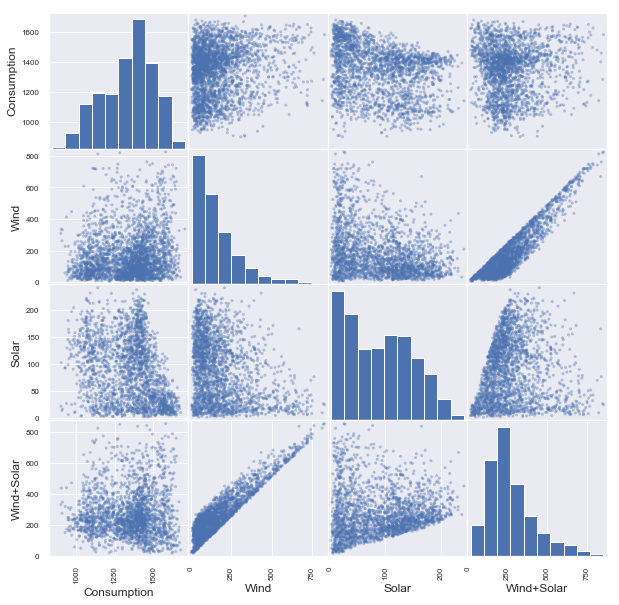

In [221]:
pd.plotting.scatter_matrix(df,alpha=0.4, figsize=(10,10))
plt.show()

#### Examples on how to create Timestamps from Strings

In [222]:
pd.to_datetime('2018-01-15 3:45pm')

Timestamp('2018-01-15 15:45:00')

In [223]:
pd.to_datetime('7/8/1952')

Timestamp('1952-07-08 00:00:00')

In [224]:
pd.to_datetime('7/8/1952', dayfirst=True)

Timestamp('1952-08-07 00:00:00')

In [225]:
pd.to_datetime(['2018-01-05', '7/8/1952', 'Oct 10, 1995'])

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

#### Other DatetimeIndex features

Another useful aspect of DatetimeIndex is that all the individual date/time components are all available as attributes such as year, month, day. We can add addtional columns in our data frame so we can access filter out data in a more convenient way later

In [226]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday_name

Let's take a random sample of the updated dataframe

In [227]:
df.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


#### Time-based indexing

Time-based indexing is one of the most powerful and conveninet features of time series. We can select data in our dataframe by indexing with the loc accessor

In [228]:
df.loc['2013-08-08']

Consumption     1291.98
Wind             79.666
Solar            93.371
Wind+Solar      173.037
Year               2013
Month                 8
Weekday        Thursday
Name: 2013-08-08 00:00:00, dtype: object

In [229]:
df.loc['2013-08-08':'2013-08-20']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday
Date,,,,,,,
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2013-08-09,1254.462,19.564,89.341,108.905,2013,8,Friday
2013-08-10,1088.538,81.408,144.125,225.533,2013,8,Saturday
2013-08-11,990.552,99.216,140.225,239.441,2013,8,Sunday
2013-08-12,1264.423,94.114,133.530,227.644,2013,8,Monday
2013-08-13,1281.806,148.391,134.048,282.439,2013,8,Tuesday
2013-08-14,1270.136,110.763,147.257,258.020,2013,8,Wednesday
2013-08-15,1230.894,41.649,161.266,202.915,2013,8,Thursday
2013-08-16,1235.737,67.690,177.432,245.122,2013,8,Friday


We can also use **partial-string indexing***

In [230]:
df.loc['2006'];

In [231]:
df.loc['2012-02'];

#### Visualizing Time Series Data

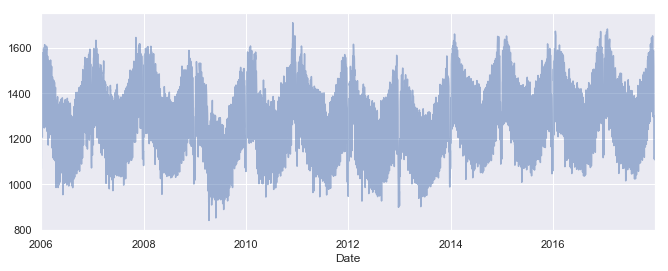

In [232]:
sns.set(rc={'figure.figsize':(11, 4)})
df['Consumption'].plot(alpha=0.5)
plt.show()

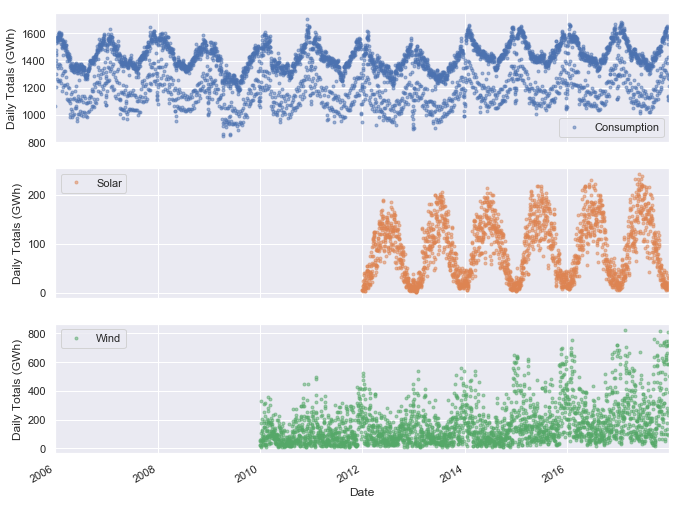

In [233]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

From the plots, there are some interesting patterns that can be point out:
- Electricity consumption is highest in winter and this could be due to increased heating and lighting usage, and it is lowest in summer (drop right in the middle of the cycle before going back up during winter)
- Electricity consumption appears to split into two clusters, one centered roughly at 1400 Gwh and the other one centered around 1150 Gwh. This might be due to one cluster corresponding to weekdays while the other one corresponds to weekends. We will investigate this guess shortly
- Solar power production is highet during summer, when sunlight is most abundant, and lowest during winter
- Wind power production is highest during winter due to high winds and storms, and is lowest in summer
- There seems to be an strong increasing trend in wind power production over the years

We can also observe from the plots that all three time series exhibit periodicity - **Seasonality**. The Consumption, Wind, and Solar time series oscillate between high and low values on a yearly scale which correspond to the seasonal changes in weather over the year. However, seasonality is not only observed during metereological seasons but it can also be observed in other cases such as in retail where sales are highest during November and December, leading up to the holidays

We can investigate futher the seasonlatiy correspoing to the clusters observed in electricity consumption for weekdday or weekend consumption. We'd like to investigate if there is weekly seasonality. Let's plot the time-series for one year to invetigate further

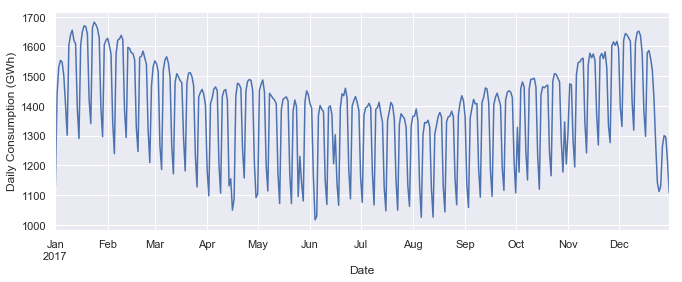

In [234]:
df.loc['2017','Consumption'].plot()
plt.ylabel('Daily Consumption (GWh)')
plt.show()

From the plot, we can clearly see the weekly oscillations. Another interesting feature shown in the plot, with a higher level of granularity, is the drastic decrease in energy consumpption in January and December

We can zoom in further to better appretiate the oscillations. Let's plot the time series for January and February

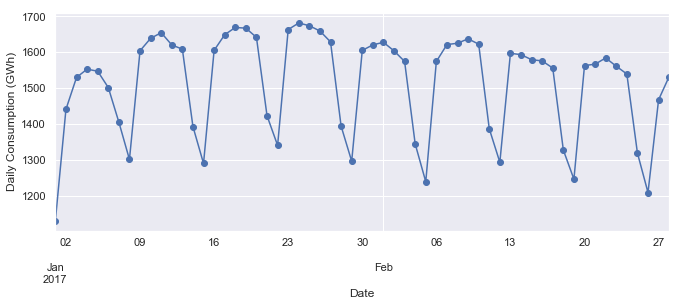

In [235]:
df.loc['2017-01':'2017-02','Consumption'].plot(marker='o',linestyle='-')
plt.ylabel('Daily Consumption (GWh)')
plt.show()

From the zoomed-in plot is even more clear that energy consumption is high during weekdays while there is a drop in energy consumption during the weekend and the 8-th day (Sunday) being the lowest point

We can add grid lines as well as add nicely formated tick lables on each Monday. So we can easily tell which days are weekdays and which days are weekends

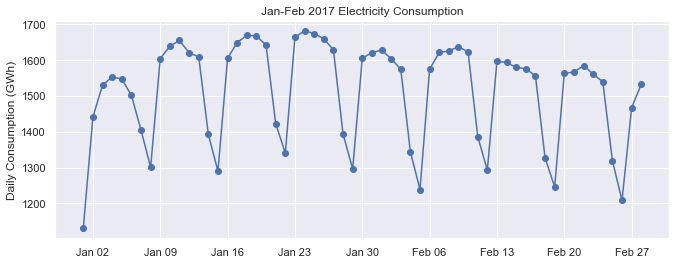

In [236]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(df.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')

# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

#### Yearly Seasonality

Let's further explore seasonality in the time seties data. We can get a better understading of the energy consumption and each renewable energy souce if we take a look at their distribution. What is the range in GWh? Is there any outliers that need to be point out?

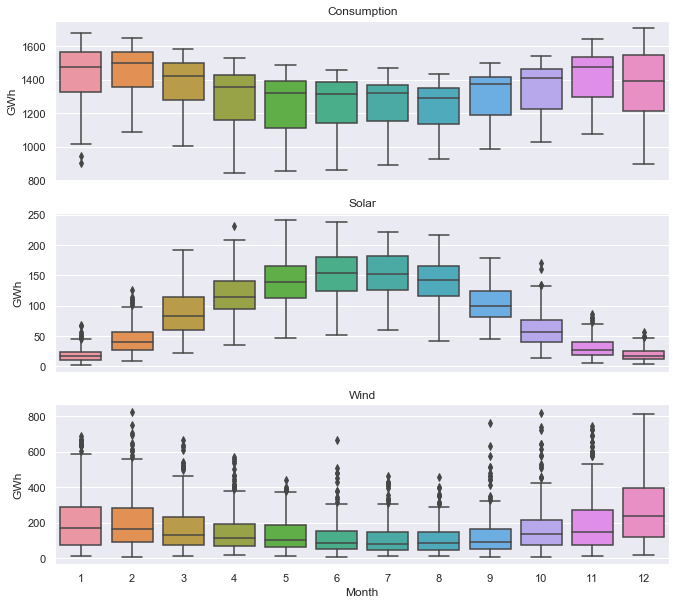

In [237]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(cols_plot, axes):
    sns.boxplot(data=df, x='Month', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)

    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')


The box plot confirm the yearly seasonality that we have observed previous for energy consumption and renewable energies. Box plots also provide additional insights:
- Although electricity consumption is highest during winter months adn lowest during the summer. Box plots show that the median and the first quartile for January and December are lower compared to the months of February and Novemeber, likely due to businessess being closed over the holidays. We observed this abrupt drop when looking at yearly energy consumption for 2017
- While Solar and Wind power production exhibit a yearly seasonality, the wind power production has many more outliers which reflect the effects of occasional extreme wind speeds with storms and other transient weather conditions

#### Weekly Seasonality

We can also use Box plots to explore weekly seasonlaity. To do this we have to group data by day of the week which can be done inside seaborn plot

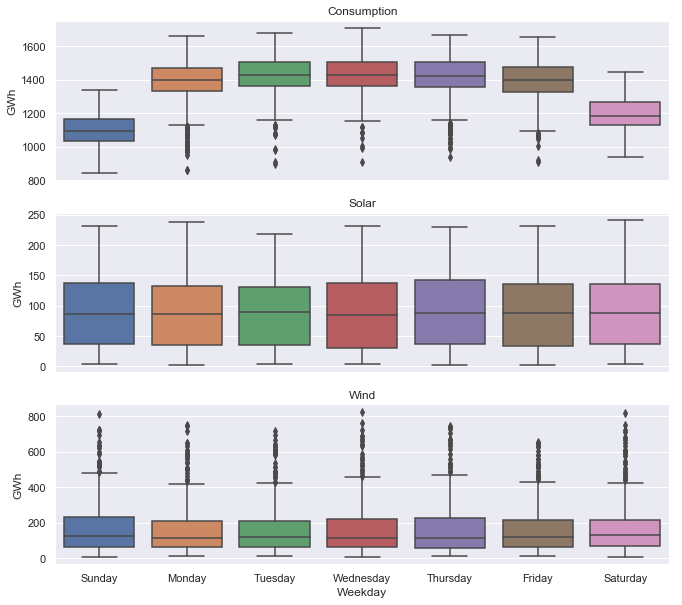

In [238]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(cols_plot, axes):
    sns.boxplot(data=df, x='Weekday', y=name, ax=ax);
    ax.set_ylabel('GWh')
    ax.set_title(name)

    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')


As expected electricity coonsumption is higher during weekdays than during weekends. The low outliers on weekdays are presumably during holidays. Solar power shows constant behaviour across all days of the week and the same is true for wind power with exception of the outliers to due effects of occasional extreme wind speeds

To dig deeper into the seasonality analysis, we can plot an Autocorrelation plot for the year 2017. Autocorrelation plots compute the correlation coefficients of the time series with itself at different time lags. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines correspond to 95% and 99% (dash line) confidence badns. We seen in the plot that 7-8 lags give highest correlation which aligns with the weekly trends

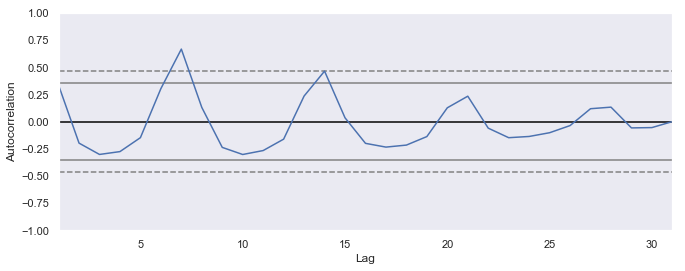

In [239]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.loc['2017-01','Consumption'])
plt.show()

When the data points of a time series are uniformly spaced in time (i.e. hourly, daily, montly, etc). The time series can be associated with a frequency. We can create a sequence of uniformly spaced dates by:

In [240]:
pd.date_range('1998-03-10', '1998-03-15', freq='D')

DatetimeIndex(['1998-03-10', '1998-03-11', '1998-03-12', '1998-03-13',
               '1998-03-14', '1998-03-15'],
              dtype='datetime64[ns]', freq='D')

In [241]:
pd.date_range('1998-03-10', '1998-03-31', freq='5D')

DatetimeIndex(['1998-03-10', '1998-03-15', '1998-03-20', '1998-03-25',
               '1998-03-30'],
              dtype='datetime64[ns]', freq='5D')

In [242]:
pd.date_range('2004-09-20', periods=8, freq='H')

DatetimeIndex(['2004-09-20 00:00:00', '2004-09-20 01:00:00',
               '2004-09-20 02:00:00', '2004-09-20 03:00:00',
               '2004-09-20 04:00:00', '2004-09-20 05:00:00',
               '2004-09-20 06:00:00', '2004-09-20 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [243]:
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [244]:
times_sample = pd.to_datetime(['2013-02-03', '2013-02-06', '2013-02-08'])
consum_sample = df.loc[times_sample, ['Consumption']].copy()
consum_sample

,Consumption
2013-02-03,1109.639
2013-02-06,1451.449
2013-02-08,1433.098


In [245]:
# Convert the data to daily frequency, without filling any missings
consum_freq = consum_sample.asfreq('D')

# Create a column with missings forward filled
consum_freq['Consumption - Forward Fill'] = consum_sample.asfreq('D', method='ffill')
consum_freq

,Consumption,Consumption - Forward Fill
2013-02-03,1109.639,1109.639
2013-02-04,NaN,1109.639
2013-02-05,NaN,1109.639
2013-02-06,1451.449,1451.449
2013-02-07,NaN,1451.449
2013-02-08,1433.098,1433.098


In the Consumption column, we have the original data, with a value of NaN for any date that was missing in our consum_sample DataFrame. In the Consumption - Forward Fill column, the missings have been forward filled, meaning that the last value repeats through the missing rows until the next non-missing value occurs.

If you’re doing any time series analysis which requires uniformly spaced data without any missings, you’ll want to use asfreq() to convert your time series to the specified frequency and fill any missings with an appropriate method.

#### Resampling

We can resample, **downsample** to observe the weekly mean time series

In [246]:
# Specify the data columns we want to include
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']

# Resample to weekly frequency, aggregating with mean
df_weekly_mean = df[data_columns].resample('W').mean()
df_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


The first row above, labelled '2006-01-01', contains the mean of all the data contained in the time bin '2006-01-01' through '2006-01-07'. The second row, labelled '2006-01-08', contains the mean data for the '2006-01-08' through '2006-01-14' time bin, and so on. By default, each row of the downsampled time series is labelled with the left edge of the time bin

By construction, our weekly time series has 1/7 as many data points as the daily time series. We can confirm this by comparing the number of rows of the two DataFrames

In [247]:
print(df.shape[0])
print(df_weekly_mean.shape[0])

4383
627


Let’s plot the daily and weekly Solar power time series together over a single six-month period to compare them

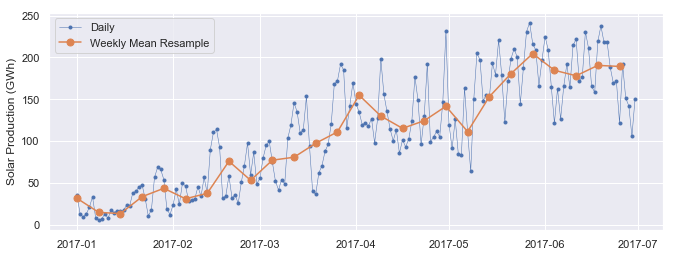

In [248]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'

# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()

ax.plot(df.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')

ax.plot(df_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=7, linestyle='-', label='Weekly Mean Resample')

ax.set_ylabel('Solar Production (GWh)')
ax.legend()
plt.show()

We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling

Now let’s resample the data to monthly frequency, aggregating with sum totals instead of the mean. Unlike aggregating with mean(), which sets the output to NaN for any period with all missing data, the default behavior of sum() will return output of 0 as the sum of missing data

In [249]:
df_monthly = df[data_columns].resample('M').sum(min_count=28)
df_monthly.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,45304.704,NaN,NaN,NaN
2006-02-28,41078.993,NaN,NaN,NaN
2006-03-31,43978.124,NaN,NaN,NaN


From the documentation of 'resmple()' it can be seen that the monthly resampled data is labelled with the end of each month (the right bin edge), whereas the weekly resampled data is labelled with the left bin edge. By default, resampled data is labelled with the right bin edge for monthly, quarterly, and annual frequencies, and with the left bin edge for all other frequencies

let’s explore the monthly time series by plotting the electricity consumption as a line plot, and the wind and solar power production together as a stacked area plot

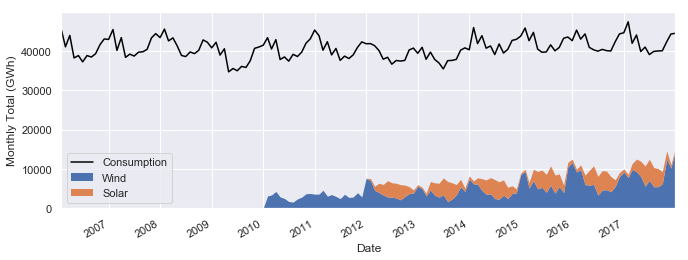

In [250]:
fig, ax = plt.subplots()
ax.plot(df_monthly['Consumption'], color='black', label='Consumption')
df_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

At this monthly time scale, we can clearly see the yearly seasonality in each time series, and it is also evident that electricity consumption has been fairly stable over time, while wind power production has been growing steadily, with wind and solar power comprising an increasing share of the electricity consumed

Let’s explore this further by resampling to annual frequency and computing the ratio of Wind+Solar to Consumption for each year

In [251]:
# Compute the annual sums, setting the value to NaN for any year which has
# fewer than 360 days of data
df_annual = df[data_columns].resample('A').sum(min_count=360)

# The default index of the resampled DataFrame is the last day of each year,
# ('2006-12-31', '2007-12-31', etc.) so to make life easier, set the index
# to the year component
df_annual = df_annual.set_index(df_annual.index.year)
df_annual.index.name = 'Year'

# Compute the ratio of Wind+Solar to Consumption
df_annual['Wind+Solar/Consumption Ratio'] = df_annual['Wind+Solar'] / df_annual['Consumption']
df_annual.tail(3)

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption Ratio
Year,,,,,
2015,505264.56300,77468.994,34907.138,112376.132,0.222410
2016,505927.35400,77008.126,34562.824,111570.950,0.220528
2017,504736.36939,102667.365,35882.643,138550.008,0.274500


In [252]:
df_annual.sort_values(by=['Wind+Solar/Consumption Ratio'])

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption Ratio
Year,,,,,
2012,469574.75400,45862.667,27887.332,73749.999,0.157057
2014,504164.82100,51107.672,32498.307,83370.502,0.165364
2013,463336.85300,47197.832,29559.780,76697.443,0.165533
2016,505927.35400,77008.126,34562.824,111570.950,0.220528
2015,505264.56300,77468.994,34907.138,112376.132,0.222410
2017,504736.36939,102667.365,35882.643,138550.008,0.274500
2006,489068.53600,NaN,NaN,NaN,NaN
2007,496631.84700,NaN,NaN,NaN,NaN
2008,495570.87600,NaN,NaN,NaN,NaN


let’s plot the wind + solar share of annual electricity consumption as a bar chart

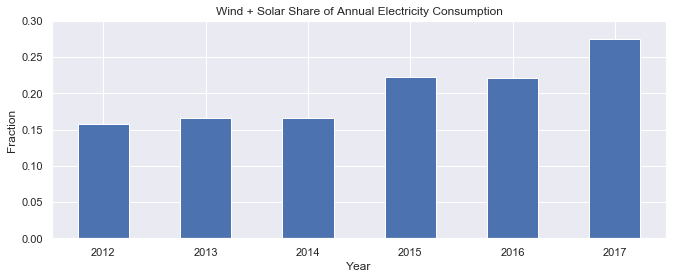

In [253]:
# Plot from 2012 onwards, because there is no solar production data in earlier years
ax = df_annual.loc[2012:, 'Wind+Solar/Consumption Ratio'].plot.bar(color='C0')
ax.set_ylabel('Fraction')
ax.set_ylim(0, 0.3)
ax.set_title('Wind + Solar Share of Annual Electricity Consumption')
plt.xticks(rotation=0)
plt.show()

We observe that there is a consistent increase in Wind+Solar Energy share in annual electricity consumption. We can see that wind + solar production as a share of annual electricity consumption has been increasing from about 15% in 2012 to about 27% in 2017

#### Rolling Widnow

Rolling window operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as mean(), median(), sum(), etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series

By default, all data points within a window are equally weighted in the aggregation, but this can be changed by specifying window types such as Gaussian, triangular, etc

Let’s use the rolling() method to compute the 7-day rolling mean of our daily data. We use the center=True argument to label each window at its midpoint, so the rolling windows are:

2006-01-01 to 2006-01-07 — labelled as 2006-01-04
2006-01-02 to 2006-01-08 — labelled as 2006-01-05
2006-01-03 to 2006-01-09 — labelled as 2006-01-06
and so on…

In [254]:
# Compute the centered 7-day rolling mean
df_7d = df[data_columns].rolling(7, center=True).mean()
df_7d.head(12)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


To visualize the differences between rolling mean and resampling, let’s update our earlier plot of January-June 2017 solar power production to include the 7-day rolling mean along with the weekly mean resampled time series and the original daily data

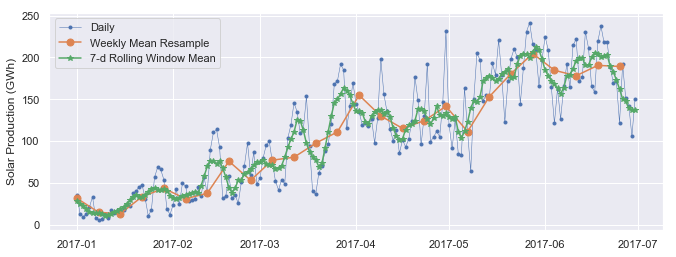

In [255]:
#Start and end of the date range to extract
start, end = '2017-01', '2017-06'

# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()

ax.plot(df.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')

ax.plot(df_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=7, linestyle='-', label='Weekly Mean Resample')

ax.plot(df_7d.loc[start:end, 'Solar'],
marker='*', linestyle='-', label='7-d Rolling Window Mean')

ax.set_ylabel('Solar Production (GWh)')
ax.legend();

We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

#### Trends

Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean tends to smooth a time series by averaging out variations at frequencies much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let’s look at rolling means on those two time scales.

We’ve already computed 7-day rolling means, so now let’s compute the 365-day rolling mean of our energy data

In [256]:
# The min_periods=360 argument accounts for a few isolated missing days in the
# wind and solar production time series

df_365d = df[data_columns].rolling(window=365, center=True, min_periods=360).mean()

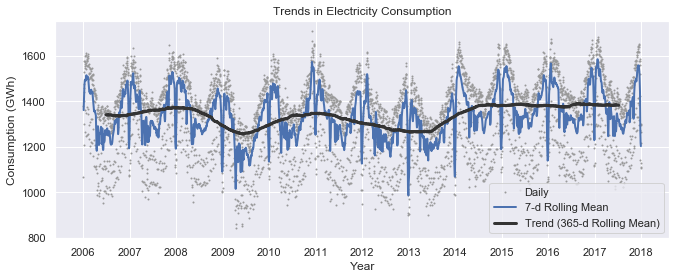

In [257]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()

ax.plot(df['Consumption'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')

ax.plot(df_7d['Consumption'], linewidth=2, label='7-d Rolling Mean')

ax.plot(df_365d['Consumption'], color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')

# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption');

- We can see that the 7-day rolling mean has smoothed out all the weekly seasonality, while preserving the yearly seasonality. The 7-day rolling mean reveals that while electricity consumption is typically higher in winter and lower in summer, there is a dramatic decrease for a few weeks every winter at the end of December and beginning of January, during the holidays.

- Looking at the 365-day rolling mean time series, we can see that the long-term trend in electricity consumption is pretty flat, with a couple of periods of anomalously low consumption around 2009 and 2012-2013.

Let’s look at trends in wind and solar production

Text(0.5, 1.0, 'Trends in Electricity Production (365-d Rolling Means)')

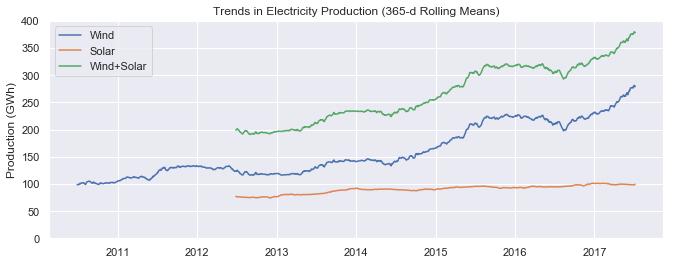

In [258]:
# Plot 365-day rolling mean time series of wind and solar power
fig, ax = plt.subplots()
for nm in ['Wind', 'Solar', 'Wind+Solar']:
    ax.plot(df_365d[nm], label=nm)

# Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylim(0, 400)
ax.legend()
ax.set_ylabel('Production (GWh)')
ax.set_title('Trends in Electricity Production (365-d Rolling Means)')

We can see a small increasing trend in solar power production and a large increasing trend in wind power production